In [1]:
import sys
sys.path.append('../')

import numpy as np
import pandas as pd
import new_SPOC
import generate_SPOC_model as gen
from numpy.linalg import norm

import matplotlib.pyplot as plt
import matplotlib
from tqdm import tqdm_notebook
from IPython.display import clear_output
%matplotlib inline 

In [2]:
matplotlib.rc('xtick', labelsize=18) 
matplotlib.rc('ytick', labelsize=18) 
matplotlib.rcParams.update({'font.size': 18})

n_nodes = 600, main_err_indices = 0.54125757808
n_nodes = 600, main_err_weights = 0.775931313159
n_nodes = 600, main_err_formula = 0.781772268248


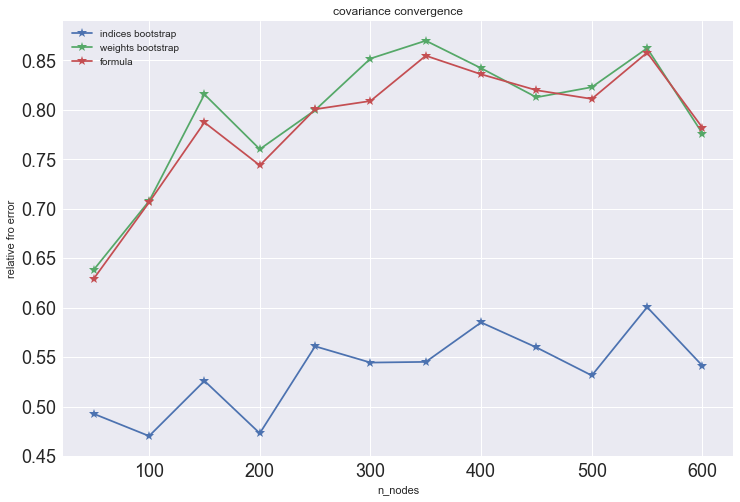

In [5]:
n_clusters = 2
pnn = 5
pn_indices = np.arange(pnn)
B = np.diag([0.5] * n_clusters)

main_error_indices = []
main_error_weights = []
main_error_formula = []
norm_direct_cov = []

for n_nodes in range(50, 650, 50):
    
    count_err_indices = [] # for random indices bootstrap
    count_err_weights = [] # for random weights bootstrap
    count_err_formula = [] # via formula from article
    count_norm_cov = []
    
    for count in tqdm_notebook(range(15)):
        
        Theta = gen.generate_theta(n_nodes, n_clusters, 
                                   pure_nodes_number=pnn, 
                                   pure_nodes_indices = pn_indices,
                                   seed=count)
        
        P = Theta.dot(B).dot(Theta.T)
        main_A = gen.P_to_A(P, reflect=True, seed=count)
        
        direct_std = []
        err_indices = []
        err_weights = []
        err_formula = []
        norm_cov = []

        # direct bootstrap 
        for i in range(300):
            tmp_A = gen.P_to_A(P, reflect=True, seed=i)
            tmp_U, L =  new_SPOC.get_U_L(tmp_A, k=n_clusters)
            direct_std.append(tmp_U)
            
        direct_std = np.array(direct_std)

        C = new_SPOC.calculate_C(main_A, n_clusters)        
        U_mean, std, bootstrap_matrix_indices = new_SPOC.calculate_mean_cov_U(main_A, C,
                                                                              n_repetitions=300, 
                                                                              return_bootstrap_matrix=True,
                                                                              bootstrap_type = "random_indices")
        
        U_mean, std, bootstrap_matrix_weights = new_SPOC.calculate_mean_cov_U(main_A, C,
                                                                     n_repetitions=300, 
                                                                     return_bootstrap_matrix=True,
                                                                     bootstrap_type = "random_weights")

        for p_index in pn_indices:
            
            direct_cov = np.cov(direct_std[:, p_index].T)
            bootstrap_cov_indices = np.cov(bootstrap_matrix_indices[:, p_index].T)
            bootstrap_cov_weights = np.cov(bootstrap_matrix_weights[:, p_index].T)
            
            bootstrap_cov_formula = np.zeros((n_clusters, n_clusters))
            for j in range(n_nodes):
                bootstrap_cov_formula += main_A[p_index,j] * np.dot(C[j,:].reshape(-1, 1),
                                                                    C[j,:].reshape(1, -1))
            
            err_indices.append(norm(direct_cov - bootstrap_cov_indices, ord="fro") / norm(direct_cov))
            err_weights.append(norm(direct_cov - bootstrap_cov_weights, ord="fro") / norm(direct_cov))
            err_formula.append(norm(direct_cov - bootstrap_cov_formula, ord="fro") / norm(direct_cov))
            norm_cov.append(norm(direct_cov))
            
        mean_indices = np.mean(err_indices)
        mean_weights = np.mean(err_weights)
        mean_formula = np.mean(err_formula)
        mean_norm = np.mean(norm_cov)
        
        count_err_indices.append(mean_indices)
        count_err_weights.append(mean_weights)
        count_err_formula.append(mean_formula)
        count_norm_cov.append(mean_norm)
        
    main_error_indices.append(np.mean(count_err_indices))
    main_error_weights.append(np.mean(count_err_weights))
    main_error_formula.append(np.mean(count_err_formula))
    norm_direct_cov.append(np.mean(count_norm_cov))
      
    clear_output()
    
    print("n_nodes = {0}, main_err_indices = {1}".format(n_nodes, main_error_indices[-1]))
    print("n_nodes = {0}, main_err_weights = {1}".format(n_nodes, main_error_weights[-1]))
    print("n_nodes = {0}, main_err_formula = {1}".format(n_nodes, main_error_formula[-1]))
    
    plt.figure(figsize=(12,8))
    plt.plot(range(50, n_nodes+50, 50), main_error_indices, 
             label="indices bootstrap", marker='*', markersize=10)
    
    plt.plot(range(50, n_nodes+50, 50), main_error_weights, 
             label="weights bootstrap", marker='*', markersize=10)
    
    plt.plot(range(50, n_nodes+50, 50), main_error_formula,
             label="formula", marker='*', markersize=10)

    
    plt.xlabel("n_nodes")
    plt.ylabel("relative fro error")
    plt.title("covariance convergence")
    plt.legend(loc="upper left")
    plt.show()
    plt.savefig("covariance_error.png") 

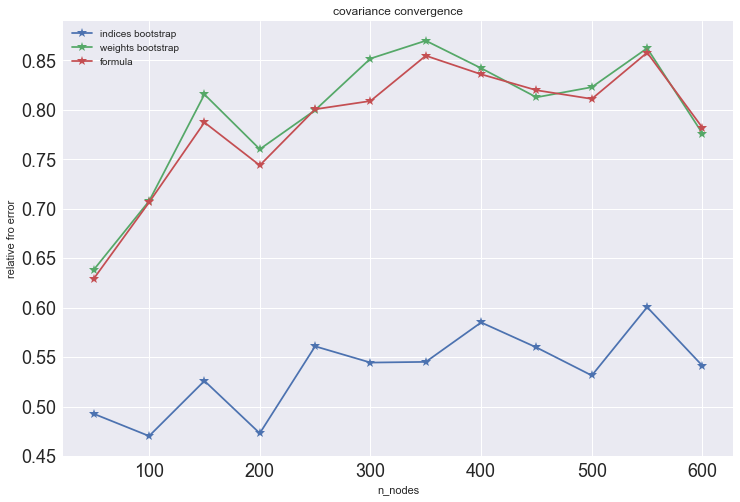

In [9]:
plt.figure(figsize=(12,8))
plt.plot(range(50, n_nodes+50, 50), main_error_indices, 
         label="indices bootstrap", marker='*', markersize=10)

plt.plot(range(50, n_nodes+50, 50), main_error_weights, 
         label="weights bootstrap", marker='*', markersize=10)

plt.plot(range(50, n_nodes+50, 50), main_error_formula,
         label="formula", marker='*', markersize=10)


plt.xlabel("n_nodes")
plt.ylabel("relative fro error")
plt.title("covariance convergence")
plt.legend(loc="upper left")
plt.savefig("covariance_error.png") 